# Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})




common_settings = {
                   # LambdaCDM parameters
                   'H0':67.556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   # 'sigma8': 0.831,
                   'ln10^{10}A_s': 3.047,
                   'n_s': 0.9665,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
}


import os 
path_to_class_sz = os.getcwd() + '/../../class_sz/'

2024-03-15 18:37:34.340462: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-15 18:37:34.340482: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-15 18:37:34.340487: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-15 18:37:34.340551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 18:37:34.340690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# HOD dictionaries

In [3]:
# best-fit from Kusiak et al. https://arxiv.org/pdf/2203.12583.pdf

HOD_0 = {
'sigma_log10M_HOD_ngal_0': 0.68660116,
'alpha_s_HOD_ngal_0':    1.3039425,
'M1_prime_HOD_ngal_0': 10**12.701308, # Msun/h
'M_min_HOD_ngal_0': 10**11.795964, # Msun/h
'M0_HOD_ngal_0' :0,
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_0':  1.0868995,
'f_cen_HOD_ngal_0' : 1., 
}

HOD_1 = {
'alpha_s_HOD_ngal_1':  1.3023026,
'sigma_log10M_HOD_ngal_1':0.97260617,
'M1_prime_HOD_ngal_1': 10**13.440975,
'M_min_HOD_ngal_1':10**13.127660,
'M0_HOD_ngal_1' :0,
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_1':2.7461961,
'f_cen_HOD_ngal_1' : 1., 
}

HOD_2 = {

'sigma_log10M_HOD_ngal_2' :  0.40339510,
'alpha_s_HOD_ngal_2' :   1.6292653,
'M1_prime_HOD_ngal_2':  10** 13.518607,
'M_min_HOD_ngal_2': 10** 12.707242,
'M0_HOD_ngal_2' :0,
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_2': 0.18379845,
'f_cen_HOD_ngal_2' : 1., 
}

HOD_common = {
'z_min': 0.005,
'z_max': 4,
'M_min': 7.0e8,
'M_max': 3.5e15,
    
'dlogell': 0.2,
'ell_max': 6000.0,
'ell_min': 2.0,
    
# precisions params:
# 'k_min_for_pk_class_sz' :  0.001,
# 'k_max_for_pk_class_sz' :  60.0,
# 'k_per_decade_class_sz' :  50,
# 'P_k_max_h/Mpc' :  50.0,

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0001,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.001,
# 'ndim_masses': 150,
'ndim_redshifts': 50,


'hm_consistency': 1,


'delta for galaxies': "200c",
'delta for matter density': "200c",
'mass function': 'T08M200c',
'concentration parameter': 'B13' ,
    
'M0 equal M_min (HOD)':'no',
'x_out_truncated_nfw_profile': 1.0,
}


## dndz files

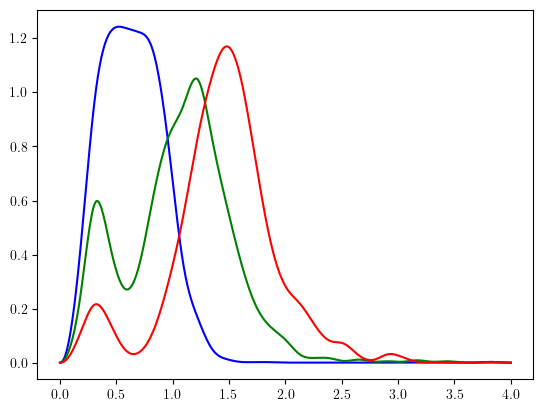

In [4]:
zuw, dnblue, dngreen, dnred = np.loadtxt(path_to_class_sz + 'class_sz_auxiliary_files/normalised_dndz_cosmos.txt',unpack=True)
plt.plot(zuw,dnblue,c='blue')
plt.plot(zuw,dngreen,c='green')
plt.plot(zuw,dnred,c='red')

In [46]:
# we save the dndz in seprate files, that's how we do. 
# np.savetxt(path_to_class_sz + 'class_sz_auxiliary_files/normalised_dndz_cosmos_0.txt',np.c_[zuw,dnblue])
# np.savetxt(path_to_class_sz + 'class_sz_auxiliary_files/normalised_dndz_cosmos_1.txt',np.c_[zuw,dngreen])
# np.savetxt(path_to_class_sz + 'class_sz_auxiliary_files/normalised_dndz_cosmos_2.txt',np.c_[zuw,dnred])

# Halo model galaxy power spectra

In [5]:
%%time
M = Class()
M.set(common_settings)
M.set(HOD_common)
M.set(HOD_0) #ngal_0
M.set(HOD_1) #ngal_1
M.set(HOD_2) #ngal_2

M.set({
'output' : 'galn_galn_1h,galn_galn_2h',
'galaxy_samples_list_num' : 3, # the number of galaxy samples
'galaxy_samples_list' : '0,1,2', # the id string of each sample, can be any integer
'full_path_and_prefix_to_dndz_ngal':path_to_class_sz + 'class_sz_auxiliary_files/normalised_dndz_cosmos_'
})

        
M.compute_class_szfast()
cl_galn_galn = M.cl_galn_galn()

CPU times: user 20 s, sys: 137 ms, total: 20.2 s
Wall time: 2.48 s


In [6]:
dict_names = {
'0':r'$\mathrm{Blue}$','1':r'$\mathrm{Green}$','2':r'$\mathrm{Red}$'
}

In [7]:
strp = list(cl_galn_galn.keys())[0]
strp.split('x')[0]

'0'

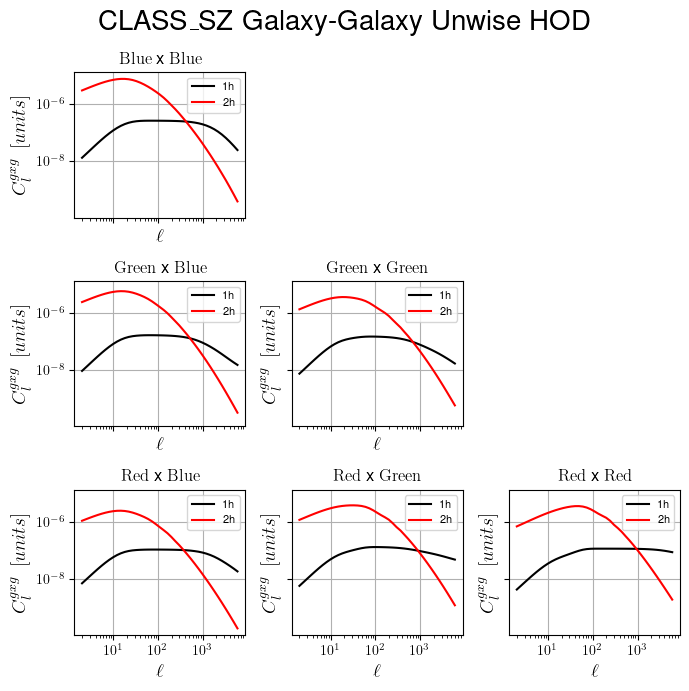

In [8]:
plot_dim = int(1/2*(-1 + np.sqrt(1 + 8*len(cl_galn_galn.keys()))))
fig, axes = plt.subplots(figsize=(7, 7), sharex=True, 
                         sharey=True, 
                         ncols=plot_dim, 
                         nrows=plot_dim,
                         )
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# x = np.linspace(0, 10, 100)
ik = 0
for i in range(plot_dim):
    for j in range(plot_dim):
        if i<j:
            axes[i, j].axis('off')
        else:
            kk = list(cl_galn_galn.keys())[ik]
            
            # axes[i, j].plot(x, np.sin((i+j) *x))
            strp = list(cl_galn_galn.keys())[ik]
            kt = dict_names[strp.split('x')[0]]+' x '+dict_names[strp.split('x')[1]]
            ik+=1
            axes[i, j].set_title(kt,size=12)
            axes[i, j].set_xlabel(r"$\ell$",fontsize=14)
            axes[i, j].set_ylabel(r"$C_l^{gxg} \,\,\, [units]$",fontsize=14)

            axes[i, j].grid()
            #
            cl = cl_galn_galn[kk]
            fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

            axes[i, j].loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',label=r'1h')
            axes[i, j].loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',label=r'2h')
            axes[i, j].legend(loc=1,fontsize=8)
fig.suptitle('CLASS_SZ Galaxy-Galaxy Unwise HOD',fontsize=20)
fig.tight_layout()
# plt.savefig('../../notebooks/class_sz_tutorial_notebooks/figures/class_sz_unwise_hod_gg.pdf')

# Halo model galaxy-cmb lensing power spectra

In [10]:
%%time
M = Class()
M.set(common_settings)
M.set(HOD_common)
M.set(HOD_0) #ngal_0
M.set(HOD_1) #ngal_1
M.set(HOD_2) #ngal_2
M.set({
'output' : 'galn_lens_1h,galn_lens_2h',
'galaxy_samples_list_num' : 3, # the number of galaxy samples
'galaxy_samples_list' : '0,1,2', # the id string of each sample, can be any integer

'full_path_and_prefix_to_dndz_ngal':path_to_class_sz + 'class_sz_auxiliary_files/normalised_dndz_cosmos_'
})

M.compute_class_szfast()
cl_galn_lens = M.cl_galn_lens()

CPU times: user 6.25 s, sys: 108 ms, total: 6.36 s
Wall time: 998 ms


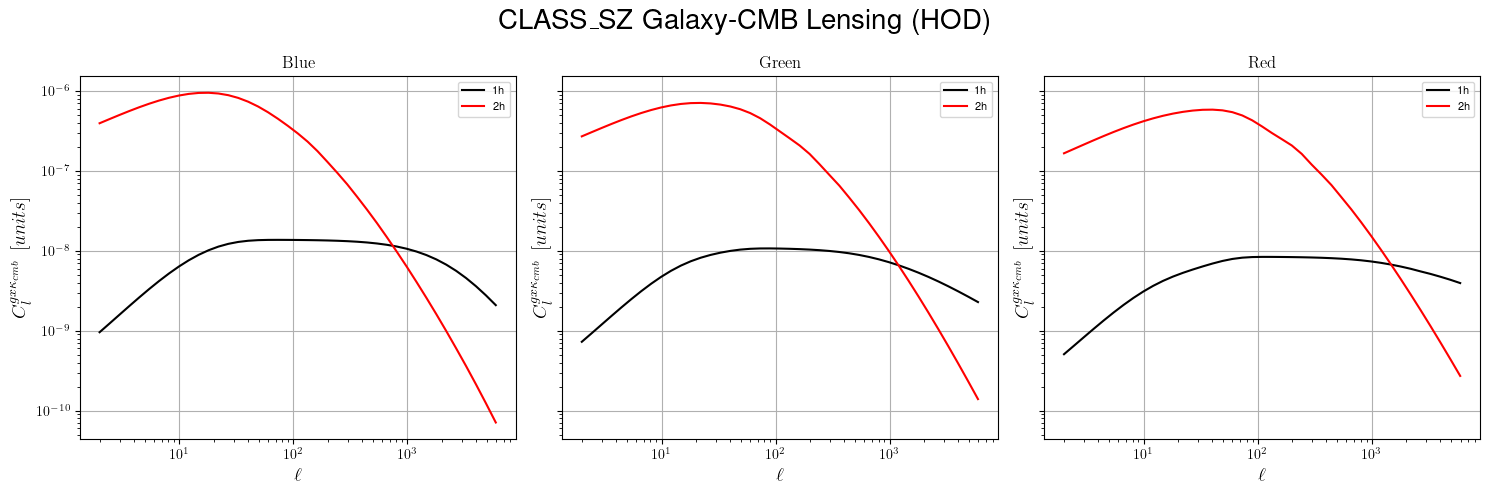

In [11]:
plot_dim = len(cl_galn_lens.keys())
fig, axes = plt.subplots(figsize=(15, 5), 
                         sharex=True, 
                         sharey=True, 
                         ncols=plot_dim
                         )
plt.subplots_adjust(#left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.4,
                    hspace=0.4)
# x = np.linspace(0, 10, 100)
ik = 0
for i in range(plot_dim):
    kk = list(cl_galn_lens.keys())[ik]
    strp = list(cl_galn_lens.keys())[ik]
    kt = dict_names[strp.split('x')[0]]
    ik+=1
    # axes[i, j].plot(x, np.sin((i+j) *x))
    
    axes[i].set_title(kt,size=12)
    axes[i].set_xlabel(r"$\ell$",fontsize=14)
    axes[i].set_ylabel(r"$C_l^{gx\kappa_{cmb}} \,\,\, [units]$",fontsize=14)

    axes[i].grid()
    
    cl = cl_galn_lens[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    axes[i].loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',label=r'1h')
    axes[i].loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',label=r'2h')
    axes[i].legend(loc=1,fontsize=8)
    
fig.suptitle('CLASS_SZ Galaxy-CMB Lensing (HOD)',fontsize=20)
fig.tight_layout()
# plt.savefig('../../notebooks/class_sz_tutorial_notebooks/figures/class_sz_unwise_hod_gkcmb.pdf')

# All in the same plot

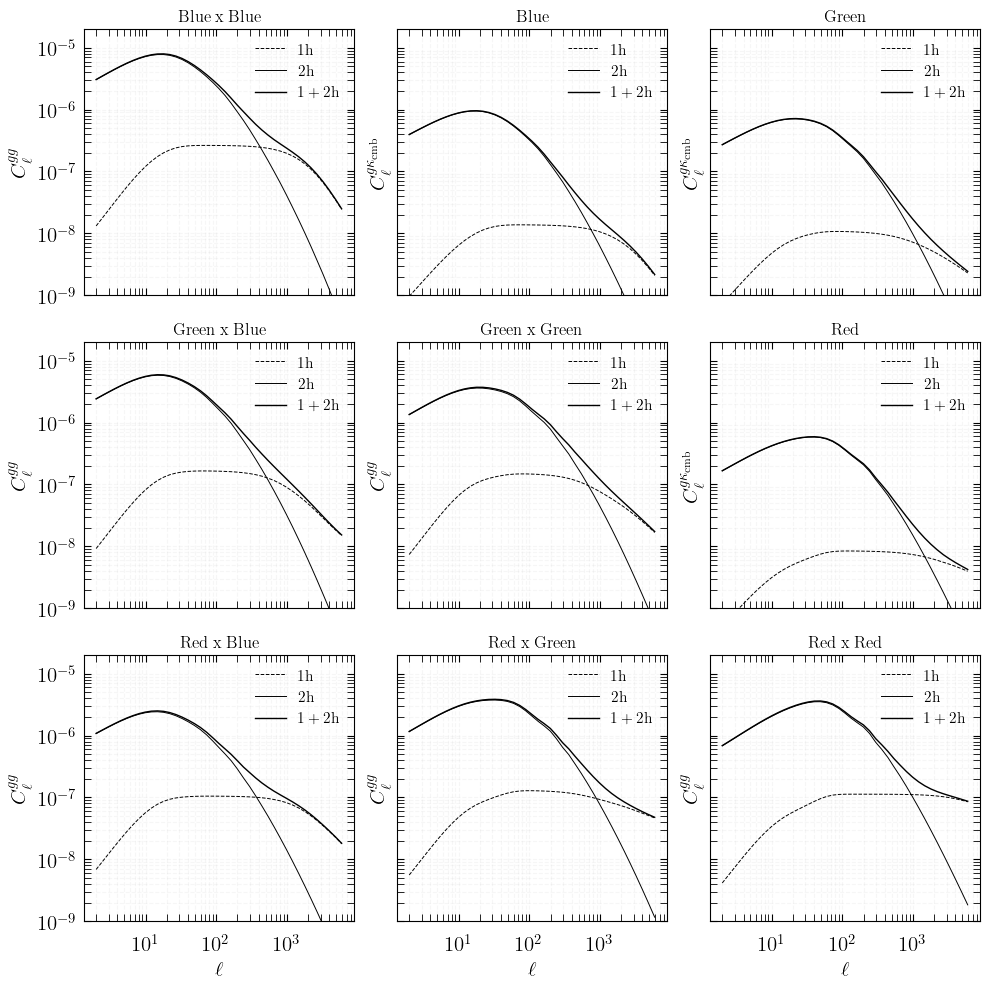

In [12]:
plot_dim = int(1/2*(-1 + np.sqrt(1 + 8*len(cl_galn_galn.keys()))))
fig, axes = plt.subplots(figsize=(10, 10),
                         sharey=True, sharex=True, 
                         ncols=plot_dim, 
                         nrows=plot_dim,
                         )
plt.subplots_adjust(left=0.1,
                    bottom=0.,
                    right=0.9,
                    # top=0.2,
                    wspace=0.1,
                    hspace=0.1)


plt.ylim(1e-9,2e-5)
label_size = 15
title_size = 15
legend_size = 13
handle_length = 1.5
# x = np.linspace(0, 10, 100)
ik = 0
ikg = 0
for i in range(plot_dim):
    for j in range(plot_dim):
        if i<j:
            # axes[i, j].axis('off')
            kk = list(cl_galn_lens.keys())[ikg]
            strp = list(cl_galn_lens.keys())[ikg]
            kt = dict_names[strp.split('x')[0]]
            # ik+=1
            # axes[i, j].plot(x, np.sin((i+j) *x))
            axes[i,j].tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
            axes[i,j].tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
            axes[i,j].xaxis.set_ticks_position('both')
            axes[i,j].yaxis.set_ticks_position('both')
            plt.setp(axes[i,j].get_yticklabels(), rotation='horizontal', fontsize=label_size)
            plt.setp(axes[i,j].get_xticklabels(), fontsize=label_size)
            axes[i,j].grid( visible=True, which="both", alpha=0.1, linestyle='--')
            
            axes[i,j].set_title(kt,size=12)
            if i == 2:
                axes[i,j].set_xlabel(r"$\ell$",fontsize=title_size)
            axes[i,j].set_ylabel(r"$C_\ell^{g\kappa_\mathrm{cmb}}$",fontsize=title_size)

            axes[i,j].grid()

            cl = cl_galn_lens[kk]
            fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

            axes[i,j].loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k--',label=r'$1\mathrm{h}$',lw=0.7)
            axes[i,j].loglog(cl['ell'],np.asarray(cl['2h'])/fac,'k-',label=r'$2\mathrm{h}$',lw=0.7)
            axes[i,j].loglog(cl['ell'],np.asarray(cl['2h'])/fac+np.asarray(cl['1h'])/fac,'k-',label=r'$1+2\mathrm{h}$',lw=1)
            axes[i, j].legend(loc=1,fontsize=11,frameon=False)           

            ikg += 1
        else:
            kk = list(cl_galn_galn.keys())[ik]
            
            # axes[i, j].plot(x, np.sin((i+j) *x))
            strp = list(cl_galn_galn.keys())[ik]
            kt = dict_names[strp.split('x')[0]]+r' $\mathrm{x}$ '+dict_names[strp.split('x')[1]]
            ik+=1
            axes[i, j].set_title(kt,size=12)
            if i == 2:
                axes[i, j].set_xlabel(r"$\ell$",fontsize=title_size)
            axes[i, j].set_ylabel(r"$C_\ell^{gg}$",fontsize=title_size)

            axes[i, j].grid()
            #
            cl = cl_galn_galn[kk]
            fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

            axes[i, j].loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k--',label=r'$1\mathrm{h}$',lw=0.7)
            axes[i, j].loglog(cl['ell'],np.asarray(cl['2h'])/fac,'k-',label=r'$2\mathrm{h}$',lw=0.7)
            axes[i,j].loglog(cl['ell'],np.asarray(cl['2h'])/fac+np.asarray(cl['1h'])/fac,'k-',label=r'$1+2\mathrm{h}$',lw=1)
            axes[i, j].legend(loc=1,fontsize=11,frameon=False)
            
            axes[i,j].tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
            axes[i,j].tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
            axes[i,j].xaxis.set_ticks_position('both')
            axes[i,j].yaxis.set_ticks_position('both')
            plt.setp(axes[i,j].get_yticklabels(), rotation='horizontal', fontsize=label_size)
            plt.setp(axes[i,j].get_xticklabels(), fontsize=label_size)
            axes[i,j].grid( visible=True, which="both", alpha=0.1, linestyle='--')            
            
# fig.suptitle('CLASS_SZ Galaxy-Galaxy and Galxy-CMB Lensing Unwise HOD',fontsize=16)
fig.tight_layout()
plt.savefig('figures/class_sz_hod_gg_and_kg.pdf')

# distances - turn over multipole

Text(0, 0.5, '$u_\\ell$')

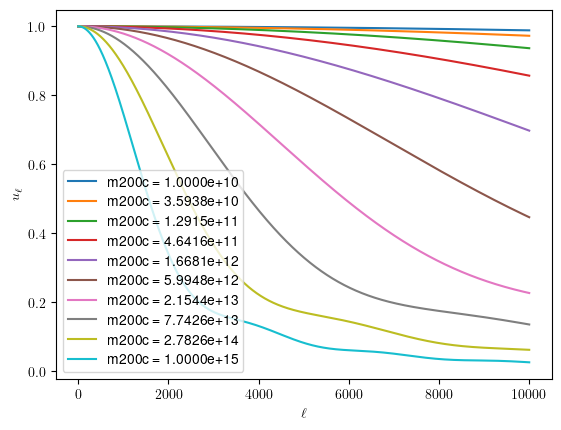

In [50]:

for m200c in np.geomspace(1e10,1e15,10):

    zs = 0.5
    delta = M.get_delta_from_delta_def_at_z(1,zs)

    lfall = M.get_dA(zs)/M.get_r_delta_of_m_delta_at_z(delta,m200c,zs)
    # print(lfall)
    rd = M.get_r_delta_of_m_delta_at_z(delta,m200c,zs)
    cd = M.get_c_delta_at_m_and_z(m200c,zs,1)
    ls = np.arange(2,10000)
    kvec = (ls+0.5)/M.get_dA(zs)
    uls = np.vectorize(M.get_truncated_nfw_profile_at_z_k_rd_cd_xout)(zs,kvec,rd,cd,1)

    plt.plot(ls,uls,label="m200c = %.4e"%m200c)

plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$u_\ell$")